## Predicting

**Importing librairies**


In [127]:
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight

import warnings
warnings.filterwarnings('ignore')
from sklearn.utils import shuffle
import geopandas as gpd
from tqdm import tqdm

**Denne nettsiden snakker litt om hvordan jobbe med ubalanserte datasett**

https://medium.com/digital-catapult/dealing-with-imbalanced-data-8b21e6deb6cd

**Importing data**

In [128]:
Filename = "data\_tarefelt1.csv"
data = pd.read_csv(Filename)


In [129]:
#Removes 90% of data labeled 0
data = data.drop(data[data['label'] == 0].sample(frac=.95).index)

In [130]:
data_x = data.drop(columns = "label")
data_x = data.drop(columns = "geometry")
data_y = data.label

**Splitting Data**

In [131]:
X_train, X_test ,y_train, y_test = train_test_split( data_x, data_y, test_size=0.30, random_state=42)
X_test, X_val ,y_test, y_val = train_test_split( X_test, y_test, test_size=0.5, random_state=42)

**Definerer en batch generator**

In [132]:
def batch(iterable_X, iterable_y, n=1):
    '''
    n: batchsize
    iterable_X: X frame to be iterated over
    iterable_y: y frame to be iterated over
    '''
    l = len(iterable_X)
    for ndx in range(0, l, n):
        yield iterable_X[ndx:min(ndx + n, l)], iterable_y[ndx:min(ndx + n, l)]


In [156]:
scaler = StandardScaler()
scaler.fit(X_train) 
scaled_X_train = scaler.transform(X_train)
X_train = pd.DataFrame(scaled_X_train, index= X_train.index, columns=X_train.columns)
scaled_X_test = scaler.transform(X_test)
X_test  = pd.DataFrame(scaled_X_test, index= X_test.index, columns=X_test.columns)

**Training the model**  


In [155]:
class_weights = compute_class_weight(class_weight = "balanced", classes= np.unique(y_train), y= y_train)
clf = SGDClassifier(max_iter=1000, tol=1e-3, class_weight= dict(zip(np.unique(y_train), class_weights)))


classes = np.unique(y_train)
accuracy =[]
ROUNDS = 2
batch_size = 10000
for _ in tqdm(range(ROUNDS), desc=" outer", position=0, total=ROUNDS):
    #X_train, y_train = shuffle(X_train, y_train)
    batcherator = batch(X_train, y_train, batch_size)
    
    for index, (X, target) in tqdm(enumerate(batcherator), desc=" inner loop",position=1, leave=True, total=70):

        #scaler = StandardScaler()
        #scaler.fit(X) 
        #X = scaler.transform(X)
        #test = scaler.transform(X_val) 
        clf.partial_fit(X, target, classes)
        y_predicted = clf.predict(X_test)
        accuracy.append(accuracy_score(y_val, y_predicted))

 outer: 100%|██████████| 2/2 [00:00<00:00,  2.43it/s]


**Evaluating Model**


[[3285 3787]
 [3780 4306]]


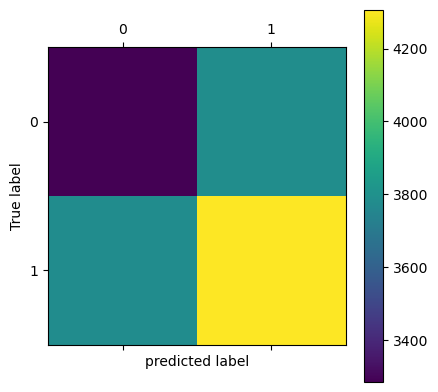

In [151]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_true=y_test, y_pred=y_predicted)

print(conf_mat)
# Plot matrix
plt.matshow(conf_mat)
plt.colorbar()
plt.ylabel("True label")
plt.xlabel("predicted label")
plt.show()

**Checking over the test set**

In [153]:
y_predicted = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_predicted)
print(f"The accuracy of the model was {np.round(accuracy,2)}")

The accuracy of the model was 0.47


In [154]:
np.count_nonzero(y_predicted)

0

In [139]:
unique, counts = np.unique(y_predicted, return_counts=True)


In [140]:
print(unique)
print(counts)

[0.]
[15158]


In [141]:
X_test

,Unnamed: 0,band_0,band_1,band_2,band_3,band_4,band_5,band_6,band_7,band_8,...,band_59,band_60,band_61,band_62,band_63,band_64,band_65,lat,lon,label
304290,304290,0,0,0,464,434,350,279,306,464,...,5934,6007,5674,5373,5837,6538,6855,62.011312,4.914506,1.0
163729,163729,0,0,0,376,297,262,355,288,405,...,5972,5836,5690,5714,5876,6430,6873,61.887682,4.908185,1.0
229137,229137,0,0,0,5292,4657,3666,2767,2964,5088,...,6580,6398,6162,5530,6002,6659,6688,62.043559,4.984119,1.0
307209,307209,0,0,0,426,391,345,274,285,440,...,5809,5889,5671,5285,5727,6260,6794,62.032115,4.928171,0.0
211188,211188,0,0,0,4233,3657,2709,2028,2231,4098,...,6046,6097,5710,5413,5775,6431,6620,62.029054,4.984264,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
282676,282676,0,0,0,367,340,251,198,223,393,...,5643,5788,5634,5081,5432,6424,6502,61.911512,4.853574,0.0
97717,97717,0,0,0,376,293,263,209,246,428,...,5419,5776,5730,5333,6002,6587,6612,61.884962,4.946289,0.0
201911,201911,0,0,0,334,354,213,213,274,381,...,5816,6022,5830,5505,5978,6665,7089,61.844850,4.853188,1.0
823643,823643,0,0,0,407,281,258,269,342,416,...,5800,5826,5583,5518,6266,6151,6663,61.967127,4.566037,0.0


In [60]:
y_test.value_counts()


0.0    141984
1.0      8016
Name: label, dtype: int64

In [61]:
8016/141984

0.05645706558485463

**Plotting the predicted seaweed and comparing with naturdirektoratet**

In [62]:
X = X_test.copy()
X["label"] = y_test
X["y_predicted"] = y_predicted
X = gpd.GeoDataFrame(X, geometry=gpd.points_from_xy(X.lon, X.lat))

df_no_seaweed = X[X["y_predicted"] == False].copy()
df_seaweed = X[X["y_predicted"] == True].copy()
df_true_seaweed = X[X["label"] == True].copy()

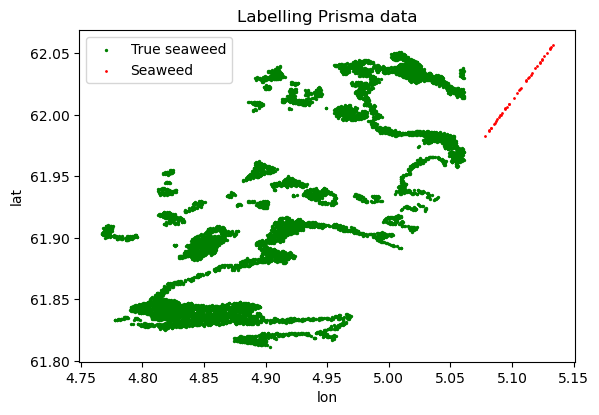

In [63]:
fig, ax = plt.subplots()
#df_no_seaweed.plot(ax = ax, color = "blue", label = "no seaweed")
df_true_seaweed.plot(ax = ax, color = "green", label = "True seaweed", markersize = 2)
df_seaweed.plot(ax = ax, color = "red", label = "Seaweed", markersize = 1)

ax.set_title("Labelling Prisma data")
ax.set_xlabel("lon")
ax.set_ylabel("lat")
ax.legend()